# Simulation of online learning


## Introduction

This code performs an online learning simulation using the CarpeDiem dataset, which is designed to predict the mortality of patients suffering from pneumonia. In this simulation, we have assigned specific dates to the ICU days of each patient to create a chronological timeline.

Initially, we train our model on data from the first month to establish a solid baseline and ensure we start with a sufficient amount of data. Following this initial training phase, we simulate an online learning scenario where the model is updated on a weekly basis with new data. This approach allows us to continuously refine the model and adapt to new patterns and trends in the data over time.

The goal of this simulation is to closely mimic a real-world scenario where new patient data becomes available periodically, and the predictive model needs to be updated regularly to maintain its accuracy and relevance

### Import libraries and file path

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, recall_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
np.random.seed(49837)

# Load datasets
file_path_Carpediem = '/Users/francesco/Desktop/script-carpediem-dataset-demographics-outcomes-and-per-day-clinical-parameters-for-critically-ill-patients-with-suspected-pneumonia-1.1.0/CarpeDiem_dataset.csv'
file_path_finaldataset = '/Users/francesco/Desktop/Training/final_dataset.csv' #file saved in the original script
df = pd.read_csv(file_path_Carpediem)
df_final = pd.read_csv(file_path_finaldataset)

# Keep only necessary columns for date calculation
df = df.drop(columns=[col for col in df.columns if col not in ['Patient_id', 'ICU_day', 'ICU_stay']])
df_original = df.copy()

### Assigning coherent random dates to patients ICU days
In this section, we will assign random yet coherent dates to each patient's ICU days to create a chronological timeline that simulates the real-world scenario of patients entering and leaving the ICU over time. This process is crucial for setting up the foundation for our online learning simulation, ensuring that the data has temporal relevance. After assigning the dates, we join this updated dataset with the cleaned and adjusted dataset produced by the original script. This step ensures that the final dataset used for the simulation is both temporally coherent and properly formatted.

Below is the code implementation:

In [2]:
# Function to assign random dates to the DataFrame
def assign_random_dates(df):
    # Initialize the 'Date' column with NaT
    df['Date'] = pd.NaT

    # Define the date range for random generation
    start_date = datetime(2024, 1, 1)
    end_date = datetime(2024, 3, 1)

    # Dictionary to keep track of the last date for each patient
    last_date_dict = {}

    # Function to generate a random date between start and end
    def random_date(start, end):
        return start + timedelta(days=np.random.randint((end - start).days))

    # Assign dates
    for index, row in df.iterrows():
        patient_id = row['Patient_id']
        icu_stay = row['ICU_stay']
        icu_day = row['ICU_day']

        if icu_day == 1 and icu_stay == 1:
            # First stay of the patient, generate a random date between start_date and end_date
            random_start_date = random_date(start_date, end_date)
            last_date_dict[patient_id] = random_start_date
        elif icu_day > 1:
            if patient_id not in last_date_dict:
                print(f"Missing initial date for patient_id {patient_id} on ICU_day {icu_day}")
                continue
            # The date should be one day after icu_day-1
            random_start_date = last_date_dict[patient_id] + timedelta(days=1)
        elif icu_day == 1 and icu_stay > 1:
            if patient_id in last_date_dict:
                # Generate a new random date that is at least sixty days after the last stay stay
                start_new_stay = last_date_dict[patient_id] + timedelta(days=3)
                if start_new_stay >= end_date:
                    start_new_stay = end_date - timedelta(days=1)
                random_start_date = random_date(start_new_stay, end_date)
            else:
                print(f"Missing initial date for patient_id {patient_id} on ICU_day {icu_day}")
                continue
            last_date_dict[patient_id] = random_start_date

        df.at[index, 'Date'] = random_start_date
        last_date_dict[patient_id] = random_start_date

    # Sort by Patient_id, ICU_stay, and ICU_day
    df = df.sort_values(by=['Patient_id', 'ICU_stay', 'ICU_day']).reset_index(drop=True)
    
    return df

# Apply the function to the DataFrame
df = assign_random_dates(df)

Missing initial date for patient_id 678 on ICU_day 2
Missing initial date for patient_id 678 on ICU_day 3
Missing initial date for patient_id 678 on ICU_day 4
Missing initial date for patient_id 678 on ICU_day 5
Missing initial date for patient_id 678 on ICU_day 6
Missing initial date for patient_id 678 on ICU_day 7
Missing initial date for patient_id 678 on ICU_day 8
Missing initial date for patient_id 678 on ICU_day 9
Missing initial date for patient_id 678 on ICU_day 10
Missing initial date for patient_id 678 on ICU_day 11
Missing initial date for patient_id 678 on ICU_day 12
Missing initial date for patient_id 678 on ICU_day 13
Missing initial date for patient_id 678 on ICU_day 14
Missing initial date for patient_id 1936 on ICU_day 2
Missing initial date for patient_id 1936 on ICU_day 3
Missing initial date for patient_id 1936 on ICU_day 4
Missing initial date for patient_id 1936 on ICU_day 5
Missing initial date for patient_id 1936 on ICU_day 6
Missing initial date for patient_id 

In [3]:
# For which patients the start date is missing?
missing_start_date_patients = df[df['Date'].isna()]['Patient_id'].unique()
print(f"For {len(missing_start_date_patients)} patients the start date is missing.")
print(missing_start_date_patients)



For 4 patients the start date is missing.
[ 678 1936 3639 9883]


In [4]:
# Show the patients for which the start date is missing (for these patients the ICU_day starts from 2)
missing = df[df['Patient_id'].isin(missing_start_date_patients)]
missing

,Patient_id,ICU_stay,ICU_day,Date
935,678,1,2,NaT
936,678,1,3,NaT
937,678,1,4,NaT
938,678,1,5,NaT
939,678,1,6,NaT
...,...,...,...,...
12401,9883,1,3,NaT
12402,9883,1,4,NaT
12403,9883,1,5,NaT
12404,9883,1,6,NaT


In [5]:
# Delete the patients for which the start date is missing from the original DataFrame and final DataFrame
df_original = df_original[~df_original['Patient_id'].isin(missing_start_date_patients)]
df_final = df_final[~df_final['Patient_id'].isin(missing_start_date_patients)]
df_original



,Patient_id,ICU_stay,ICU_day
0,43,1,1
1,43,1,2
2,43,1,3
3,43,1,4
4,43,1,5
...,...,...,...
12490,9997,1,25
12491,9997,1,26
12492,9997,1,27
12493,9997,1,28


In [6]:
df = df_original #Dataframe without the patients for which the start date is missing
df = assign_random_dates(df) #Assign random dates to the dataframe without the patients for which the start date is missing

In [7]:
# Example of a patient with multiple ICU_stay to see coherence of the dates
pat_2245 = df[df['Patient_id'] == 2245]
pat_2245


,Patient_id,ICU_stay,ICU_day,Date
3233,2245,1,1,2024-01-21
3234,2245,1,2,2024-01-22
3235,2245,1,3,2024-01-23
3236,2245,2,1,2024-02-15
3237,2245,2,2,2024-02-16
3238,2245,2,3,2024-02-17
3239,2245,2,4,2024-02-18
3240,2245,2,5,2024-02-19
3241,2245,2,6,2024-02-20
3242,2245,2,7,2024-02-21


In [8]:
# Join the two dataframes based on the Patient_id, ICU_day and ICU_stay
# The final dataframe will have the same columns as the original one (from the other script), but with the 'Date' column
final_df = pd.merge(df_final, df, on=['Patient_id', 'ICU_day', 'ICU_stay'], how='left')
df = final_df
df

,Patient_id,Binary_outcome,Age,Gender,BMI,Admit_APS_score,Number_of_ICU_stays,Tracheostomy_flag,ICU_stay,ICU_day,...,Patient_category_COVID-19,Patient_category_Other Pneumonia,Patient_category_Other Viral Pneumonia,Episode_category_CAP,Episode_category_HAP,Episode_category_Non-PNA-ctrl,Episode_category_VAP,pca_0,pca_1,Date
0,43,0,72,0,29.67,60,1,False,1,2,...,1,0,0,1,0,0,0,-2.102935,1.049171,2024-01-23
1,43,0,72,0,29.67,60,1,False,1,3,...,1,0,0,1,0,0,0,-1.927248,2.669936,2024-01-24
2,43,0,72,0,29.67,60,1,False,1,4,...,1,0,0,1,0,0,0,-1.634087,2.435101,2024-01-25
3,43,0,72,0,29.67,60,1,False,1,5,...,1,0,0,1,0,0,0,-1.608333,2.642355,2024-01-26
4,43,0,72,0,29.67,60,1,False,1,6,...,1,0,0,1,0,0,0,-1.243638,1.447292,2024-01-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10182,9997,0,42,0,32.15,111,1,False,1,25,...,0,0,0,0,0,0,0,-0.855777,-2.033782,2024-02-13
10183,9997,0,42,0,32.15,111,1,False,1,26,...,0,0,0,0,0,0,0,-0.877743,-2.161095,2024-02-14
10184,9997,0,42,0,32.15,111,1,False,1,27,...,0,0,0,0,0,0,0,-0.931115,-2.106659,2024-02-15
10185,9997,0,42,0,32.15,111,1,False,1,28,...,0,0,0,0,0,0,0,-0.950482,-2.136459,2024-02-16


### Splitting the Dataset for Initial Training and Online Learning
In this section, we split the available dataset into two parts:

- First Month Data: This subset includes data from the first month, which will be used to train an initial model. Training on this data provides a solid baseline and ensures that the model starts with a sufficient number of observations. This is crucial for establishing an effective starting point for our predictions.

- Remaining Year Data: The rest of the dataset, covering the subsequent months, will be used for the online learning simulation. This data will be split and processed on a weekly basis to mimic a real-world scenario where new data becomes available periodically. The model will be updated weekly with new data, allowing it to continuously learn and adapt to new patterns over time.

In [9]:
# Split the dataset into the part: first month and the rest
df['Date'] = pd.to_datetime(df['Date'])

# Define the date range for the split
start_date = datetime(2024, 1, 1)
split_date = start_date + timedelta(days=30)

# Split the dataset
df_first_month = df[df['Date'] <= split_date]
df_rest = df[df['Date'] > split_date]

# Check the split
print(f"First month: {df_first_month.shape[0]} records")
print(f"Rest of the year: {df_rest.shape[0]} records")

First month: 2395 records
Rest of the year: 7792 records


In [10]:
#Class weight for the first month (inverting proportion of the binary outcome)
balance = df_first_month['Binary_outcome'].value_counts(normalize=True)
class_weight = {0: balance[1], 1: balance[0]}
class_weight

{0: 0.023799582463465554, 1: 0.9762004175365344}

### Initializing and Training the SGDClassifier
In this section, we initialize an SGDClassifier model with specific parameters and perform a grid search to find the best hyperparameters for our initial model training. The steps include:

- Model Initialization: We start by initializing the SGDClassifier with the loss function set to 'log_loss' and some other parameters.
- Parameter Grid Definition: We define a grid of parameters to explore during the grid search.
- Scorer Definition: The scoring metric for the grid search is set to the ROC AUC score.
- Cross-Validation Setup: We use a 3-fold cross-validation strategy to evaluate the model performance.
- Grid Search Configuration: We create a GridSearchCV object to perform an exhaustive search over the specified parameter grid.
- Data Splitting: The dataset for the first month is split into training and testing sets.
- Data Scaling: Features are scaled using StandardScaler to standardize the data.
- Grid Search Execution: We run the grid search on the training data to find the best hyperparameters.
- Model Evaluation: The best model is evaluated on the test set, and metrics such as the ROC AUC score are calculated.
- Final Model Training: The best model is retrained on the full training data.


In [11]:
# Initializing the SGDClassifier model
model = SGDClassifier(loss='log_loss', random_state=42, n_jobs=-1)

# Defining the parameter grid to explore
param_grid = {
    'alpha': [0.1],
    'max_iter': [30000],
    'penalty': ['l1', 'l2'],
    'class_weight': [class_weight],
    'learning_rate': ['adaptive', 'optimal'],
    'eta0': [0.01,],
    'tol': [1e-3,],
}

# Defining the scoring metric for grid search (ROC AUC)
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

# Setting up 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Creating the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=kf, verbose=1, n_jobs=-1)

# Define features (from feature selection of original script) and target
features = ['Age',
 'ICU_day',
 'SOFA_score',
 'Temperature',
 'Heart_rate',
 'Mean_arterial_pressure',
 'Norepinephrine_rate',
 'Respiratory_rate',
 'Oxygen_saturation',
 'Urine_output',
 'FiO2',
 'Hemoglobin',
 'Platelets',
 'Bicarbonate',
 'Creatinine',
 'Bilirubin',
 'bal_score',
 'Scaled_not_cured_episodes',
 'Episode_duration_cumulative',
 'Cumulative_intubation',
 'GCS_score',
 'pca_0',
 'pca_1','Scaled_cured_episodes',
 'Episode_category_VAP']

target = 'Binary_outcome'

# Split the dataset into training and testing

X_train_first_month, X_test_first_month, y_train_first_month, y_test_first_month = train_test_split(df_first_month[features], df_first_month[target], test_size=0.1, random_state=42, stratify=df_first_month[target])

#Standardize the features
scaler = StandardScaler()
X_train_first_month = scaler.fit_transform(X_train_first_month)
X_test_first_month = scaler.transform(X_test_first_month)

# Perform grid search on the first month dataset
grid_search.fit(X_train_first_month, y_train_first_month)

# Display the best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_first_month = best_model.predict(X_test_first_month)
y_pred_proba_first_month = best_model.predict_proba(X_test_first_month)[:, 1]

# Calculate and print the ROC AUC score
roc_auc_first_month = roc_auc_score(y_test_first_month, y_pred_proba_first_month)
print(f"Initial AUC (First month): {roc_auc_first_month}")


# Fit the best model on the complete training data
best_model.fit(X_train_first_month, y_train_first_month)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters found:
{'alpha': 0.1, 'class_weight': {0: 0.023799582463465554, 1: 0.9762004175365344}, 'eta0': 0.01, 'learning_rate': 'optimal', 'max_iter': 30000, 'penalty': 'l2', 'tol': 0.001}
Initial AUC (First month): 0.8945868945868947


SGDClassifier(alpha=0.1,
              class_weight={0: 0.023799582463465554, 1: 0.9762004175365344},
              eta0=0.01, loss='log_loss', max_iter=30000, n_jobs=-1,
              random_state=42)

### Simulating Online Learning with Weekly Updates
In this section, we simulate an online learning environment where the model is updated weekly using new data from the rest of the year. The steps are as follows:

- Scaling Features: We scale the features of the remaining dataset using the same scaler that was fitted on the first month's data.
- Creating Weekly Batches: We divide the remaining dataset into weekly batches.
- Initializing Metrics Storage: Lists are initialized to store AUC scores for each week.
- Updating the Model: For each weekly batch, we calculate class weights based on the current batch. If the batch contains at least two classes, update the model using the current batch and sample weights. If not (or empty week), we use the metric of previus week.
- Predict probabilities on the initial test set and calculate the AUC score.
- Plotting the AUC Scores: We plot the AUC scores over the weeks to visualize the model's performance over time.

Below is the code implementation:

Batch: 2024-02-01 00:00:00 - 2024-02-04 00:00:00| AUC: 0.8952991452991452|
Batch: 2024-02-05 00:00:00 - 2024-02-11 00:00:00| AUC: 0.8938746438746439|
Batch: 2024-02-12 00:00:00 - 2024-02-18 00:00:00| AUC: 0.8952991452991453|
Batch: 2024-02-19 00:00:00 - 2024-02-25 00:00:00| AUC: 0.8924501424501424|
Batch: 2024-02-26 00:00:00 - 2024-03-03 00:00:00| AUC: 0.8924501424501424|
Batch: 2024-03-04 00:00:00 - 2024-03-10 00:00:00| AUC: 0.8981481481481481|
Batch: 2024-03-11 00:00:00 - 2024-03-17 00:00:00| AUC: 0.8952991452991453|
Batch: 2024-03-18 00:00:00 - 2024-03-24 00:00:00| AUC: 0.8938746438746439|
Batch: 2024-03-25 00:00:00 - 2024-03-31 00:00:00| AUC: 0.8938746438746439|
Batch: 2024-04-01 00:00:00 - 2024-04-07 00:00:00| AUC: 0.896011396011396|
Batch: 2024-04-08 00:00:00 - 2024-04-14 00:00:00| AUC: 0.8967236467236468|
Batch: 2024-04-15 00:00:00 - 2024-04-21 00:00:00| AUC: 0.8967236467236468|
Batch: 2024-04-22 00:00:00 - 2024-04-28 00:00:00| AUC: 0.8981481481481481|
Batch: 2024-04-29 00:00:00

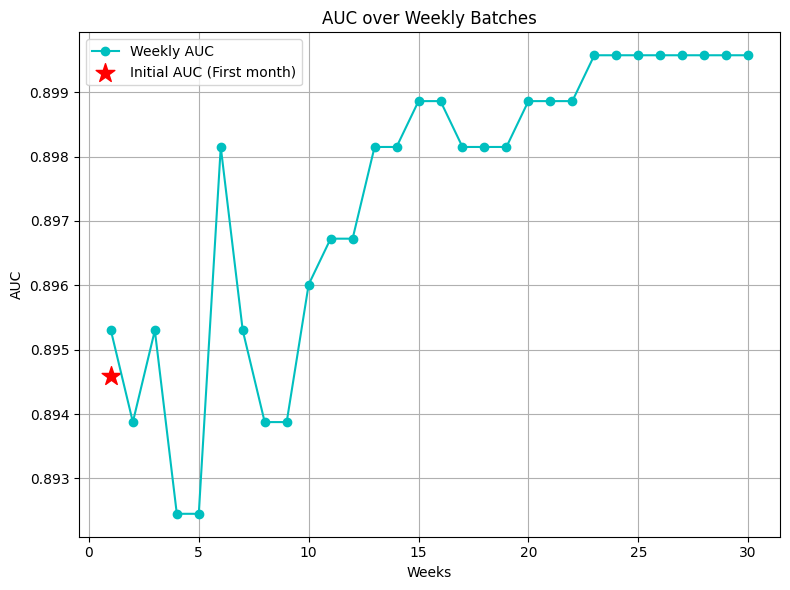

In [12]:
# Scale the features of the rest of the year using the same scaler used for the first month
X_scaled = pd.DataFrame(scaler.transform(df_rest.loc[:, features]), columns=features, index=df_rest.index)
X_scaled['Date'] = df_rest['Date']
X_scaled['Binary_outcome'] = df_rest['Binary_outcome']


# Simulate update with weekly batches from df_rest
weekly_batches = [group for _, group in X_scaled.groupby(pd.Grouper(key='Date', freq='W'))]

# Initialize lists to store metrics
aucs = []
last_valid_auc = roc_auc_first_month

for batch in weekly_batches:
    if batch.empty:
        continue
    
    X_batch = batch[features]
    y_batch = batch[target]
    
    if X_batch.empty or y_batch.empty:
        continue
    
    # Calculate class weights for the current batch
    class_counts = y_batch.value_counts(normalize=True)
    
    # Check if there are at least two classes in the batch
    if len(class_counts) < 2:
        # If there is only one class, use the last valid metrics
        auc = last_valid_auc
    else:
        # Create the class weights dictionary
        class_weights = {0: class_counts.get(1, 0), 1: class_counts.get(0, 0)}  # Using get() to handle missing keys
        
        # Convert class weights to sample weights
        sample_weights = np.array([class_weights[y] for y in y_batch])
        
        # Update model coefficients with the current batch and sample weights
        best_model.partial_fit(X_batch, y_batch, classes=np.unique(y_batch), sample_weight=sample_weights)
        
        # Predict probabilities for the current batch evaluating on the test set
        
        y_pred_first_month = best_model.predict(X_test_first_month)
        y_pred_proba_first_month = best_model.predict_proba(X_test_first_month)[:, 1]

        # Calculate metrics
        auc = roc_auc_score(y_test_first_month, y_pred_proba_first_month)
        
        # Update the last valid metrics
        last_valid_auc = auc
    
    # Append metric to list
    aucs.append(auc)

    # Print batch details (optional)
    print(f"Batch: {batch['Date'].min()} - {batch['Date'].max()}| AUC: {auc}|")

# Plot AUC
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(aucs) + 1), aucs, marker='o', linestyle='-', color='c', label='Weekly AUC')
plt.scatter(1, roc_auc_first_month, color='r', marker='*', s=200, label='Initial AUC (First month)')
plt.title('AUC over Weekly Batches')
plt.xlabel('Weeks')
plt.ylabel('AUC')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

In [13]:
#how many weeks are in weekly_batches
len(weekly_batches)

32

In [14]:
#which week is empty
for i in range(len(weekly_batches)):
    if weekly_batches[i].empty:
        print(i)
        
        

28
30


### Impact of Weekly Observations on Model Performance
The results of our online learning simulation are likely influenced by the number of weekly observations available in each batch.

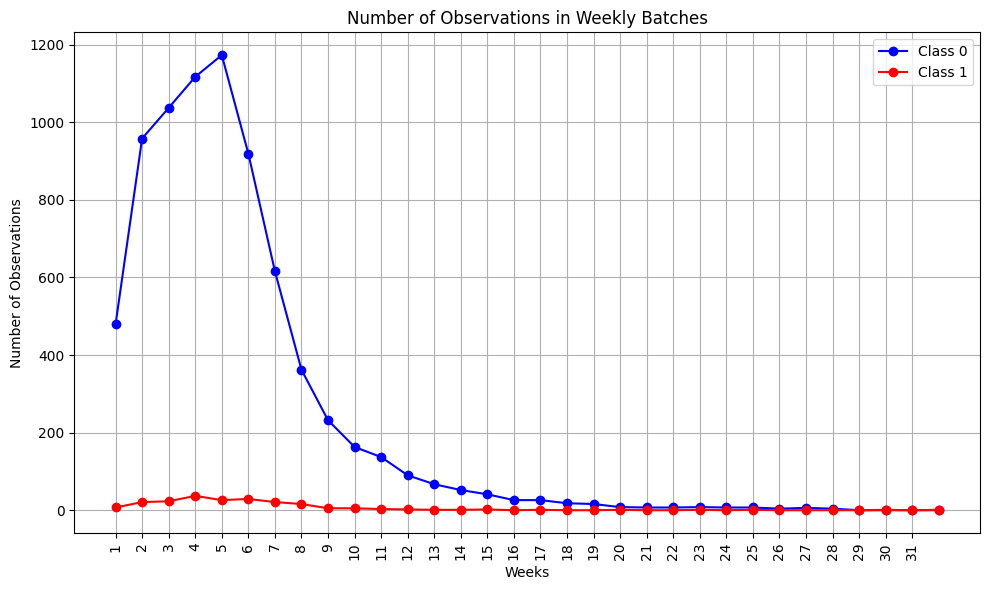

In [15]:
# Plot the trend of the number of observations in the weekly batches for binary outcome 0 and 1 

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(weekly_batches) + 1), [batch['Binary_outcome'].value_counts().get(0, 0) for batch in weekly_batches], marker='o', linestyle='-', color='b', label='Class 0')
plt.plot(range(1, len(weekly_batches) + 1), [batch['Binary_outcome'].value_counts().get(1, 0) for batch in weekly_batches], marker='o', linestyle='-', color='r', label='Class 1')
plt.title('Number of Observations in Weekly Batches')
plt.xlabel('Weeks')
plt.ylabel('Number of Observations')
plt.xticks(range(1, len(weekly_batches)), rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Conclusion
This project presents a simulation of online learning applied to predict patient mortality in the ICU. While our approach demonstrates the potential of continuous model updates using new data, it is important to recognize that this is a preliminary simulation. Further improvements and more detailed studies are necessary to develop more accurate and robust models.